In [114]:
import pymysql
import sqlalchemy
import pandas as pd
import numpy as np
import sklearn
import imblearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from collections import Counter 
from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

#from sqlalchemy import inspect
#from sqlalchemy import create_engine

In [113]:
#1.Load the dataset and explore the variables.
df = pd.read_csv('customer_churn.csv')
df
pd.show_versions()


INSTALLED VERSIONS
------------------
commit           : 06d230151e6f18fdb8139d09abf539867a8cd481
python           : 3.8.5.final.0
python-bits      : 64
OS               : Windows
OS-release       : 10
Version          : 10.0.19041
machine          : AMD64
processor        : Intel64 Family 6 Model 140 Stepping 1, GenuineIntel
byteorder        : little
LC_ALL           : None
LANG             : None
LOCALE           : English_United States.1252

pandas           : 1.4.1
numpy            : 1.21.5
pytz             : 2021.3
dateutil         : 2.8.1
pip              : 20.2.4
setuptools       : 50.3.0.post20201006
Cython           : None
pytest           : None
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : None
html5lib         : None
pymysql          : 1.0.2
psycopg2         : None
jinja2           : 2.11.2
IPython          : 7.18.1
pandas_datareader: None
bs4              : None
bottleneck       :

In [115]:
prof = ProfileReport(df)
prof.to_file(output_file='customer_churn_profile.html')

OSError: 'C:\\Users\\W10\\anaconda3\\envs\\ClassFede1\\lib\\site-packages\\pandas_profiling\\pandas_profiling.mplstyle' not found in the style library and input is not a valid URL or path; see `style.available` for list of available styles

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
7038    False
7039    False
7040    False
7041    False
7042    False
Length: 7043, dtype: bool

In [5]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

There are no nulls, no duplicates.

In [6]:
#standardizing columns names
df.columns=df.columns.str.lower()
df

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [7]:
#2. We will try to predict variable Churn using a logistic regression on variables tenure, SeniorCitizen,MonthlyCharges.
#3. Extract the target variable.

#preparing y
y_raw = pd.DataFrame()
y_raw['churn'] = df['churn']
y_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   churn   7043 non-null   object
dtypes: object(1)
memory usage: 55.1+ KB


In [8]:
y_raw = y_raw['churn'].replace(['No', 'Yes'],[0,1])
y_raw.unique()

array([0, 1], dtype=int64)

In [9]:
# 4. Extract the independent variables and scale them
#preparing X
X_raw= df[['tenure','seniorcitizen','monthlycharges']]
X_raw.info()
X_raw

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tenure          7043 non-null   int64  
 1   seniorcitizen   7043 non-null   int64  
 2   monthlycharges  7043 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 165.2 KB


,tenure,seniorcitizen,monthlycharges
0,1,0,29.85
1,34,0,56.95
2,2,0,53.85
3,45,0,42.30
4,2,0,70.70
...,...,...,...
7038,24,0,84.80
7039,72,0,103.20
7040,11,0,29.60
7041,4,1,74.40


In [10]:
#scale them
scaler = MinMaxScaler()
X_raw[['tenure','seniorcitizen','monthlycharges']] = scaler.fit_transform(X_raw[['tenure','seniorcitizen','monthlycharges']]) #.values.reshape(-1,1))

<ipython-input-10-116eeac98bdb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_raw[['tenure','seniorcitizen','monthlycharges']] = scaler.fit_transform(X_raw[['tenure','seniorcitizen','monthlycharges']]) #.values.reshape(-1,1))


In [11]:
X_raw

,tenure,seniorcitizen,monthlycharges
0,0.013889,0.0,0.115423
1,0.472222,0.0,0.385075
2,0.027778,0.0,0.354229
3,0.625000,0.0,0.239303
4,0.027778,0.0,0.521891
...,...,...,...
7038,0.333333,0.0,0.662189
7039,1.000000,0.0,0.845274
7040,0.152778,0.0,0.112935
7041,0.055556,1.0,0.558706


In [12]:
#Defining y and X
y = y_raw
X = X_raw

In [54]:
y.shape

(7043,)

In [13]:
# 5.Build the logistic regression model.
logreg = LogisticRegression(max_iter=300) #set up

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=40) #assign the data

In [15]:
model1=logreg.fit(X_train,y_train) #training the model

In [16]:
#predicting y from X_test
y_pred = model1.predict(X_test) #predicting y

In [17]:
# 6.Evaluate the model.
accuracy_score(y_test,y_pred)

0.7827733080927591

In [18]:
cm =confusion_matrix(y_test,y_pred, labels=model1.classes_)
cm

array([[1409,  144],
       [ 315,  245]], dtype=int64)

In [19]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model1.classes_)

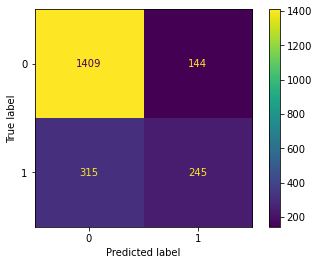

In [20]:
disp.plot()

In [21]:
#calculare recall
recall = np.diag(cm) / np.sum(cm, axis = 1)
recall_0 = recall[0]
recall_1 = recall[1]
recall_0
recall_1

0.4375

In [22]:
#calculate precision
precision = np.diag(cm) / np.sum(cm, axis = 0)
precision

array([0.81728538, 0.62982005])

7. Even a simple model will give us more than 70% accuracy. Why?
I guess because the samples are imbalanced, there are too many 'not churn' compared to the 'churn'.

8. Synthetic Minority Oversampling TEchnique (SMOTE) is an over sampling technique based on nearest neighbors that adds new points between existing points. Apply imblearn.over_sampling.SMOTE to the dataset. Build and evaluate the logistic regression model. Is it there any improvement?

In [39]:
sm = SMOTE(random_state=54)
X_res,y_res = sm.fit_resample(X_raw,y_raw)

In [52]:
counter = Counter(y_res)
print(counter)

Counter({0: 5174, 1: 5174})


In [24]:
#X_res, y_res = SMOTE().fit_resample(X, y)

In [79]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_res,y_res, test_size=0.3, random_state=40) #assign the data

In [80]:
#y_res.test2.shape()

In [81]:
model_sm=logreg.fit(X_train_sm,y_train_sm) #training the model

In [82]:
#predicting y from X_test
y_pred_sm = model_sm.predict(X_test_sm) #predicting y

In [83]:
# 6.Evaluate the model.
accuracy_score(y_test_sm,y_pred_sm)

0.7371980676328502

In [84]:
cm_sm =confusion_matrix(y_test_sm,y_pred_sm, labels=model_sm.classes_)
cm_sm

array([[1105,  403],
       [ 413, 1184]], dtype=int64)

In [86]:
disp_sm = ConfusionMatrixDisplay(confusion_matrix=cm_sm,display_labels=model_sm.classes_)

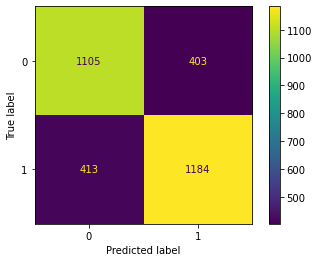

In [87]:
disp_sm.plot()

In [88]:
target_names = ['No', 'Yes']
report_smote = print(classification_report(y_test_sm, y_pred_sm, target_names=target_names))

              precision    recall  f1-score   support

          No       0.73      0.73      0.73      1508
         Yes       0.75      0.74      0.74      1597

    accuracy                           0.74      3105
   macro avg       0.74      0.74      0.74      3105
weighted avg       0.74      0.74      0.74      3105



In [89]:
#Build and evaluate the logistic regression model. Is it there any improvement?
#yes, we can now predict around 2/3 of the churnings

Tomek links are pairs of very close instances, but of opposite classes. 
Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process. 
Apply imblearn.under_sampling.TomekLinks to the dataset. 
Build and evaluate the logistic regression model. Is it there any improvement?

In [90]:
tl = TomekLinks()
X_res2, y_res2 = tl.fit_resample(X_raw,y_raw)

In [91]:
counter1 = Counter(y_res2)
print(counter1)

Counter({0: 4693, 1: 1869})


In [93]:
X_train_tm, X_test_tm, y_train_tm, y_test_tm = train_test_split(X_res2,y_res2, test_size=0.3, random_state=40) #assign the data

In [94]:
model_tm=logreg.fit(X_train_tm,y_train_tm) #training the model

In [95]:
#predicting y from X_test
y_pred_tm = model_tm.predict(X_test_tm) #predicting y

In [96]:
# 6.Evaluate the model.
accuracy_score(y_test_tm,y_pred_tm)

0.7856780091416963

In [97]:
cm_tm =confusion_matrix(y_test_tm,y_pred_tm, labels=model_tm.classes_)
cm_tm

array([[1264,  145],
       [ 277,  283]], dtype=int64)

In [98]:
disp_tm = ConfusionMatrixDisplay(confusion_matrix=cm_tm,display_labels=model_tm.classes_)

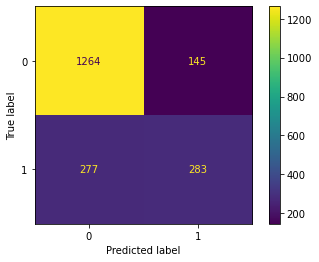

In [99]:
disp_tm.plot()

In [78]:
target_names = ['No', 'Yes']
report_tomek = print(classification_report(y_test3, y_pred3, target_names=target_names))

              precision    recall  f1-score   support

          No       0.82      0.90      0.86      1409
         Yes       0.66      0.51      0.57       560

    accuracy                           0.79      1969
   macro avg       0.74      0.70      0.71      1969
weighted avg       0.78      0.79      0.78      1969



#it improved but not that much

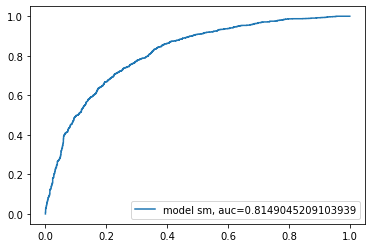

In [100]:
#ROC for the best model:SMOTE
y_pred_probability = model_sm.predict_proba(X_test_sm)[::,1]
fpr,tpr,_=roc_curve(y_test_sm, y_pred_probability)
auc=roc_auc_score(y_test_sm,y_pred_probability)
plt.plot(fpr,tpr,label='model sm, auc='+str(auc))
plt.legend(loc=4)
plt.show()